# **Pneumonia and COVID-19 Identification**

## **1. Imports and data retrieval**

In [ ]:
import os
import numpy as np
import pandas as pd
import opendatasets as od
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.regularizers import l1, l2
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc

import warnings
warnings.filterwarnings('ignore')

plt.style.use('dark_background')
sns.set_palette('Pastel2')

In [ ]:
# Downloading the dataset from Kaggle using the opendatasets library
# Make sure you have your Kaggle API key and username
dataset = 'https://www.kaggle.com/datasets/preetviradiya/covid19-radiography-dataset'
od.download(dataset)

Skipping, found downloaded files in "./covid19-radiography-dataset" (use force=True to force download)


In [ ]:
# Checking the contents of the dataset
os.listdir('covid19-radiography-dataset')

['.DS_Store', 'metadata.csv', 'COVID-19_Radiography_Dataset']

In [ ]:
# Further checking the contents of the dataset
data_dir = 'covid19-radiography-dataset/COVID-19_Radiography_Dataset'
os.listdir(data_dir)

['COVID-19_Radiography_Dataset']

In [ ]:
data_dir = data_dir + '/COVID-19_Radiography_Dataset'
# Checking again
os.listdir(data_dir)

['.DS_Store', 'Viral Pneumonia', 'Lung_Opacity', 'Normal', 'COVID']

In [ ]:
# Reading the metadata
meta_df = pd.read_csv('covid19-radiography-dataset/metadata.csv')
meta_df.head()

,Unnamed: 0,file_name,image_data_grayscale,file_format,image_shape,label
0,0,COVID-1.png,[[185 40 0 ... 0 24 131]\n [ 75 14 0 ...,PNG,"(299, 299)",COVID
1,1,COVID-10.png,[[135 133 131 ... 24 21 19]\n [132 130 129 ...,PNG,"(299, 299)",COVID
2,2,COVID-100.png,[[ 62 10 0 ... 197 200 209]\n [ 35 6 0 ...,PNG,"(299, 299)",COVID
3,3,COVID-1000.png,[[162 162 162 ... 4 4 5]\n [ 26 26 26 ...,PNG,"(299, 299)",COVID
4,4,COVID-1001.png,[[ 0 0 0 ... 0 0 0]\n [ 0 0 0 ...,PNG,"(299, 299)",COVID


In [ ]:
# Adding the labels to the filenames
meta_df['file_name'] = meta_df.apply(lambda x: f"{data_dir}/{x['label']}/{x['file_name']}", axis=1)
meta_df.head()

,Unnamed: 0,file_name,image_data_grayscale,file_format,image_shape,label
0,0,covid19-radiography-dataset/COVID-19_Radiograp...,[[185 40 0 ... 0 24 131]\n [ 75 14 0 ...,PNG,"(299, 299)",COVID
1,1,covid19-radiography-dataset/COVID-19_Radiograp...,[[135 133 131 ... 24 21 19]\n [132 130 129 ...,PNG,"(299, 299)",COVID
2,2,covid19-radiography-dataset/COVID-19_Radiograp...,[[ 62 10 0 ... 197 200 209]\n [ 35 6 0 ...,PNG,"(299, 299)",COVID
3,3,covid19-radiography-dataset/COVID-19_Radiograp...,[[162 162 162 ... 4 4 5]\n [ 26 26 26 ...,PNG,"(299, 299)",COVID
4,4,covid19-radiography-dataset/COVID-19_Radiograp...,[[ 0 0 0 ... 0 0 0]\n [ 0 0 0 ...,PNG,"(299, 299)",COVID


In [ ]:
# For each file_name check if that file exists
for file in meta_df['file_name']:
    if not os.path.exists(file):
        print(f"File {file} does not exist")

## **2. Data Exploration**

In [ ]:
# Find number of duplicates
meta_df["Unnamed: 0"].duplicated().sum()

0

In [ ]:
# Removing unnecessary columns from the metadata
img_shape = meta_df["image_shape"][0]
meta_df = meta_df.drop(columns=["Unnamed: 0", "image_data_grayscale", "file_format", "image_shape"])
meta_df.head()
print(img_shape)

(299, 299)


In [ ]:
# Checking different classes and their distribution
meta_df.label.value_counts()

label
Normal             10192
Lung_Opacity        6012
COVID               3616
Viral Pneumonia     1345
Name: count, dtype: int64

In [ ]:
# Checking for missing values
meta_df.isnull().sum()

file_name    0
label        0
dtype: int64

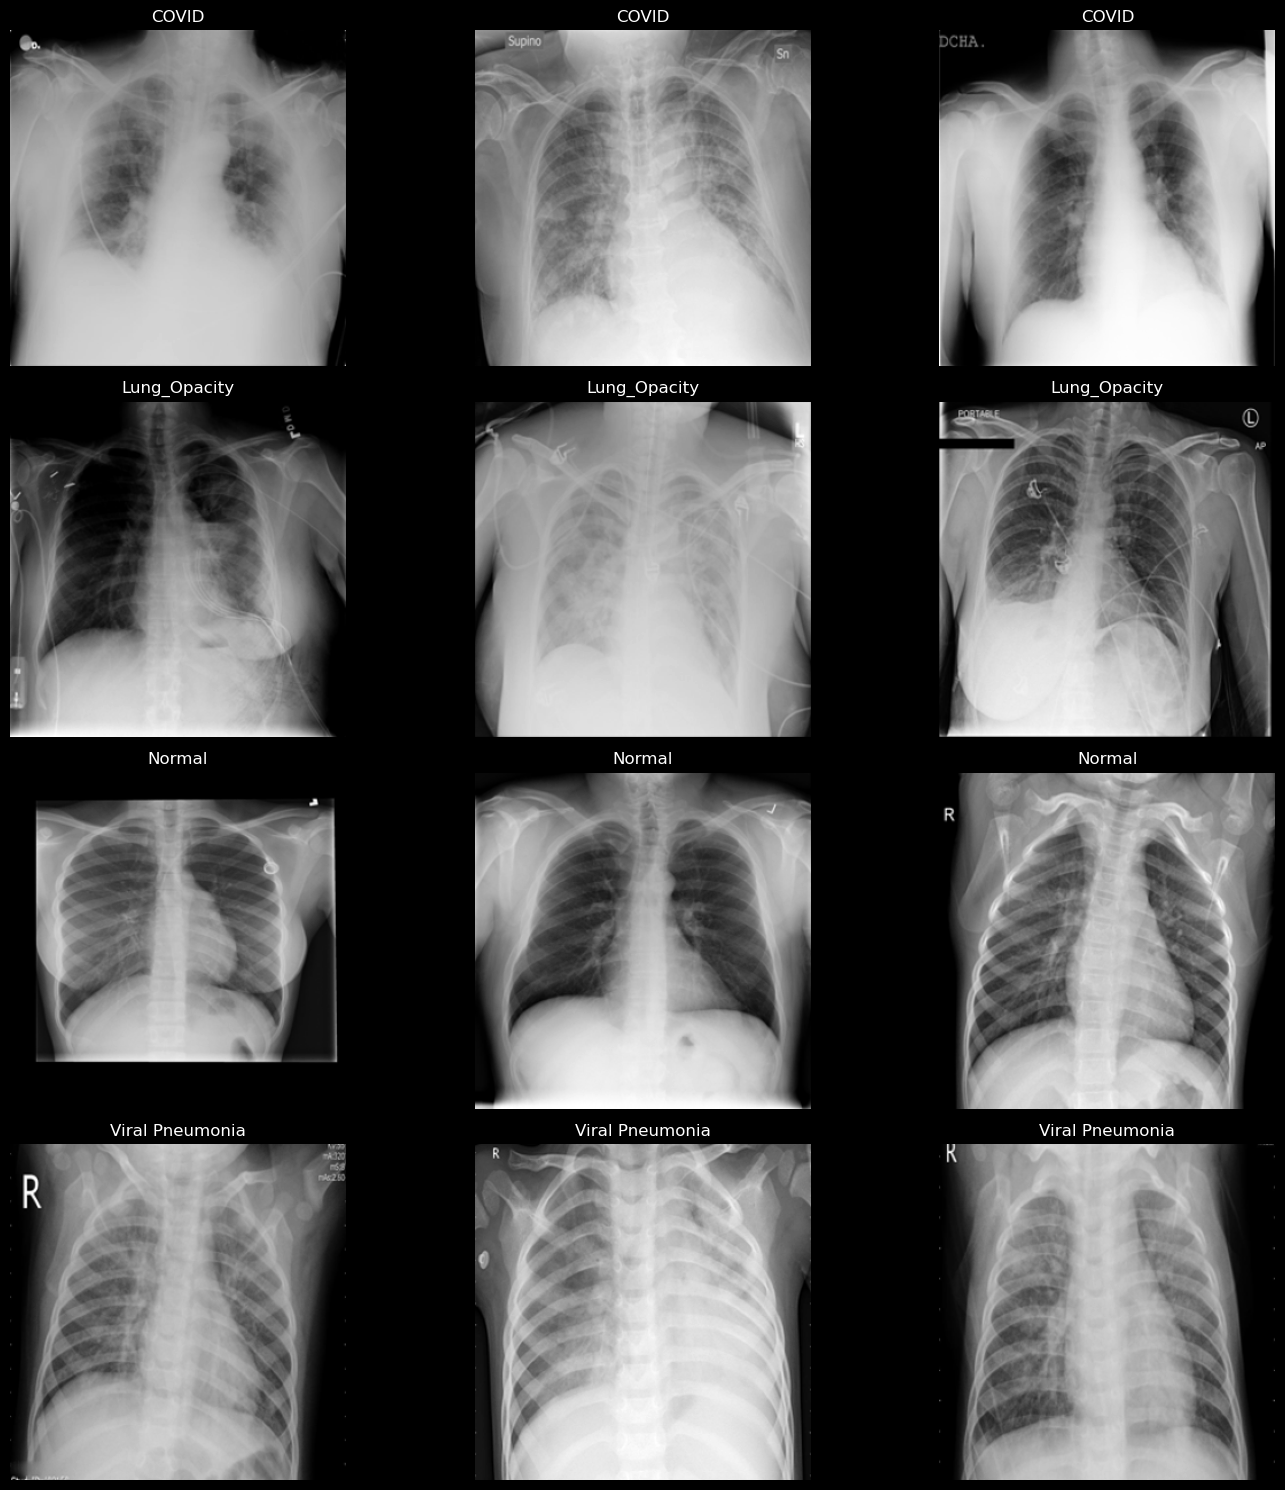

In [ ]:
# Plotting three images from each class
fig, axes = plt.subplots(4, 3, figsize=(15, 15))

for i, label in enumerate(meta_df['label'].unique()):
    # Select the first three images for the current label
    label_images = meta_df[meta_df['label'] == label].head(3)
    for j, (_, row) in enumerate(label_images.iterrows()):
        img_path = row['file_name']
        img = plt.imread(img_path)
        axes[i, j].imshow(img, cmap='gray')
        axes[i, j].set_title(label)
        axes[i, j].axis('off')

# Thhis hides empty subplots
for ax in axes.flat:
    ax.axis('off')

plt.tight_layout()
plt.show()

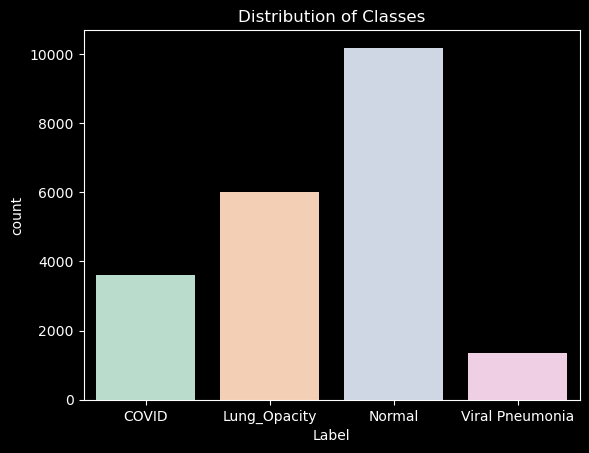

In [ ]:
# Plotting the distribution of classes
sns.countplot(x='label', data=meta_df)
plt.xlabel('Label')
plt.title('Distribution of Classes')
plt.show()

## **3. Data Splitting and Transformation**

In [ ]:
# Defining split ratios
# To achieve a 80-10-10 split
train_split = 0.8
test_split = 0.1

# Split data into train, test, and validation sets
train_df, test_valid_df = train_test_split(meta_df, train_size=train_split, random_state=123)

# Calculate the split ratio for the combined test and validation sets
test_valid_split = test_split / (1 - train_split)

# Split test+validation set into test and validation sets
test_df, valid_df = train_test_split(test_valid_df, test_size=0.5, random_state=123)

# Print lengths of resulting dataframes
print('train_df length:', len(train_df), 'test_df length:', len(test_df), 'valid_df length:', len(valid_df))

train_df length: 16932 test_df length: 2116 valid_df length: 2117


In [ ]:
# Checking the distribution of classes in the train, test, and validation sets
print(train_df.label.value_counts())
print(test_df.label.value_counts())
print(valid_df.label.value_counts())

label
Normal             8117
Lung_Opacity       4824
COVID              2922
Viral Pneumonia    1069
Name: count, dtype: int64
label
Normal             1021
Lung_Opacity        597
COVID               356
Viral Pneumonia     142
Name: count, dtype: int64
label
Normal             1054
Lung_Opacity        591
COVID               338
Viral Pneumonia     134
Name: count, dtype: int64


In [ ]:
# Resetting the index of the dataframes
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
valid_df.reset_index(drop=True, inplace=True)

In [ ]:
img_shape = img_shape[1:-1].split(', ')
img_shape = tuple([int(dim) for dim in img_shape])
img_shape

(299, 299)

In [ ]:
# Augmenting the images
# Create a data generator for training data with data augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create a data generator for validation and test data.
# Data augmentation is not used here, but the images are rescaled
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,)

# Flow from directory with specified batch size and target image size
# For the train, test, and validation sets
batch_size = 32

class_mode = 'categorical'

# Flow training images
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='file_name',
    y_col='label',
    class_mode='categorical',  # Use 'categorical' for multi-class classification
    target_size=img_shape[:2],
    batch_size=batch_size
)

# Flow validation images
valid_generator = valid_datagen.flow_from_dataframe(
    valid_df,
    x_col='file_name',
    y_col='label',
    class_mode='categorical',  # Use 'categorical' for multi-class classification
    target_size=img_shape[:2],
    batch_size=batch_size
)

# Checking the class indices
print(train_generator.class_indices)

Found 16932 validated image filenames belonging to 4 classes.
Found 2117 validated image filenames belonging to 4 classes.
Found 2116 validated image filenames belonging to 4 classes.
{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}


In [ ]:
import pickle
# Saving the class indices
with open('class_indices.pkl', 'wb') as f:
    pickle.dump(train_generator.class_indices, f)

In [ ]:
# Retrieve a batch of data from the generator
batch_data, batch_labels = train_generator.next()  # Correct

# Print the shape of the batch data and labels
print("Batch Data Shape:", batch_data.shape)
print("Batch Labels Shape:", batch_labels.shape)

# Optionally, print some samples from the batch
for i in range(min(5, batch_data.shape[0])):
    print("Sample", i+1, "Label:", batch_labels[i])

Batch Data Shape: (32, 299, 299, 3)
Batch Labels Shape: (32, 4)
Sample 1 Label: [0. 1. 0. 0.]
Sample 2 Label: [0. 0. 1. 0.]
Sample 3 Label: [1. 0. 0. 0.]
Sample 4 Label: [0. 0. 1. 0.]
Sample 5 Label: [0. 1. 0. 0.]


## **4. Model Training**

In [ ]:
# Load InceptionV3 model with pre-trained weights
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
# Freeze all layers in the base model
for layer in base_model.layers:
    print(layer.name)
    layer.trainable = False

2024-03-16 22:39:07.870805: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-03-16 22:39:07.870826: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-03-16 22:39:07.870832: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-03-16 22:39:07.870884: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-16 22:39:07.870917: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


input_1
conv2d
batch_normalization
activation
conv2d_1
batch_normalization_1
activation_1
conv2d_2
batch_normalization_2
activation_2
max_pooling2d
conv2d_3
batch_normalization_3
activation_3
conv2d_4
batch_normalization_4
activation_4
max_pooling2d_1
conv2d_8
batch_normalization_8
activation_8
conv2d_6
conv2d_9
batch_normalization_6
batch_normalization_9
activation_6
activation_9
average_pooling2d
conv2d_5
conv2d_7
conv2d_10
conv2d_11
batch_normalization_5
batch_normalization_7
batch_normalization_10
batch_normalization_11
activation_5
activation_7
activation_10
activation_11
mixed0
conv2d_15
batch_normalization_15
activation_15
conv2d_13
conv2d_16
batch_normalization_13
batch_normalization_16
activation_13
activation_16
average_pooling2d_1
conv2d_12
conv2d_14
conv2d_17
conv2d_18
batch_normalization_12
batch_normalization_14
batch_normalization_17
batch_normalization_18
activation_12
activation_14
activation_17
activation_18
mixed1
conv2d_22
batch_normalization_22
activation_22
conv2d

In [ ]:
# Number of layers in the base model
len(base_model.layers)

311

In [ ]:
num_classes = len(train_df.label.value_counts())
num_classes

4

In [ ]:
base_model = InceptionV3(include_top=False, weights="imagenet", input_shape=img_shape + (3,), pooling='max')

x = base_model.output
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
x = Dense(256, kernel_regularizer = l2(l=0.016), activity_regularizer = l1(0.006),
          bias_regularizer = l1(0.006), activation = 'relu')(x)
x = Dropout(rate=0.45, seed=123)(x)

output = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define model callbacks
checkpoint = ModelCheckpoint("incv3_v2.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, mode='max', restore_best_weights=True)

# Train the model using generators with more epochs
history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=5,  # Increase the number of epochs for better training
                    validation_data=valid_generator,
                    validation_steps=len(valid_generator),
                    callbacks=[checkpoint, early_stopping],
                    verbose=1)

Epoch 1/5


2024-03-16 22:39:15.467038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


530/530 [==============================] - ETA: 0s - loss: 21.3596 - accuracy: 0.4711
Epoch 1: val_accuracy improved from -inf to 0.51535, saving model to incv3_v2.h5
530/530 [==============================] - 853s 2s/step - loss: 21.3596 - accuracy: 0.4711 - val_loss: 11.6082 - val_accuracy: 0.5154
Epoch 2/5
530/530 [==============================] - ETA: 0s - loss: 6.4808 - accuracy: 0.6236
Epoch 2: val_accuracy improved from 0.51535 to 0.71138, saving model to incv3_v2.h5
530/530 [==============================] - 793s 1s/step - loss: 6.4808 - accuracy: 0.6236 - val_loss: 5.0091 - val_accuracy: 0.7114
Epoch 3/5
530/530 [==============================] - ETA: 0s - loss: 3.1313 - accuracy: 0.6930
Epoch 3: val_accuracy did not improve from 0.71138
530/530 [==============================] - 778s 1s/step - loss: 3.1313 - accuracy: 0.6930 - val_loss: 2.4827 - val_accuracy: 0.6693
Epoch 4/5
530/530 [==============================] - ETA: 0s - loss: 1.9704 - accuracy: 0.7373
Epoch 4: val_ac

### **5. Model Evaluation**

In [ ]:
def tr_plot(tr_data, start_epoch):
    # Extracting data
    tacc = tr_data.history['accuracy']
    tloss = tr_data.history['loss']
    vacc = tr_data.history['val_accuracy']
    vloss = tr_data.history['val_loss']

    # Generating epochs
    epochs = range(start_epoch, start_epoch + len(tacc))

    # Finding best epochs
    index_loss = np.argmin(vloss)
    index_acc = np.argmax(vacc)

    # Creating labels for best epochs
    sc_label = f'best epoch = {index_loss + 1 + start_epoch}'
    vc_label = f'best epoch = {index_acc + 1 + start_epoch}'

    # Creating the plot
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

    # Plotting training and validation loss
    axes[0].plot(epochs, tloss, 'lightpink', label='Training loss')
    axes[0].plot(epochs, vloss, 'lightblue', label='Validation loss')
    axes[0].scatter(index_loss + 1 + start_epoch, vloss[index_loss], s=150, c='lightyellow', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    # Plotting training and validation accuracy
    axes[1].plot(epochs, tacc, 'lightpink', label='Training Accuracy')
    axes[1].plot(epochs, vacc, 'lightblue', label='Validation Accuracy')
    axes[1].scatter(index_acc + 1 + start_epoch, vacc[index_acc], s=150, c='lightyellow', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    # Adjusting layout
    plt.tight_layout()

    # Displaying the plot
    plt.show()

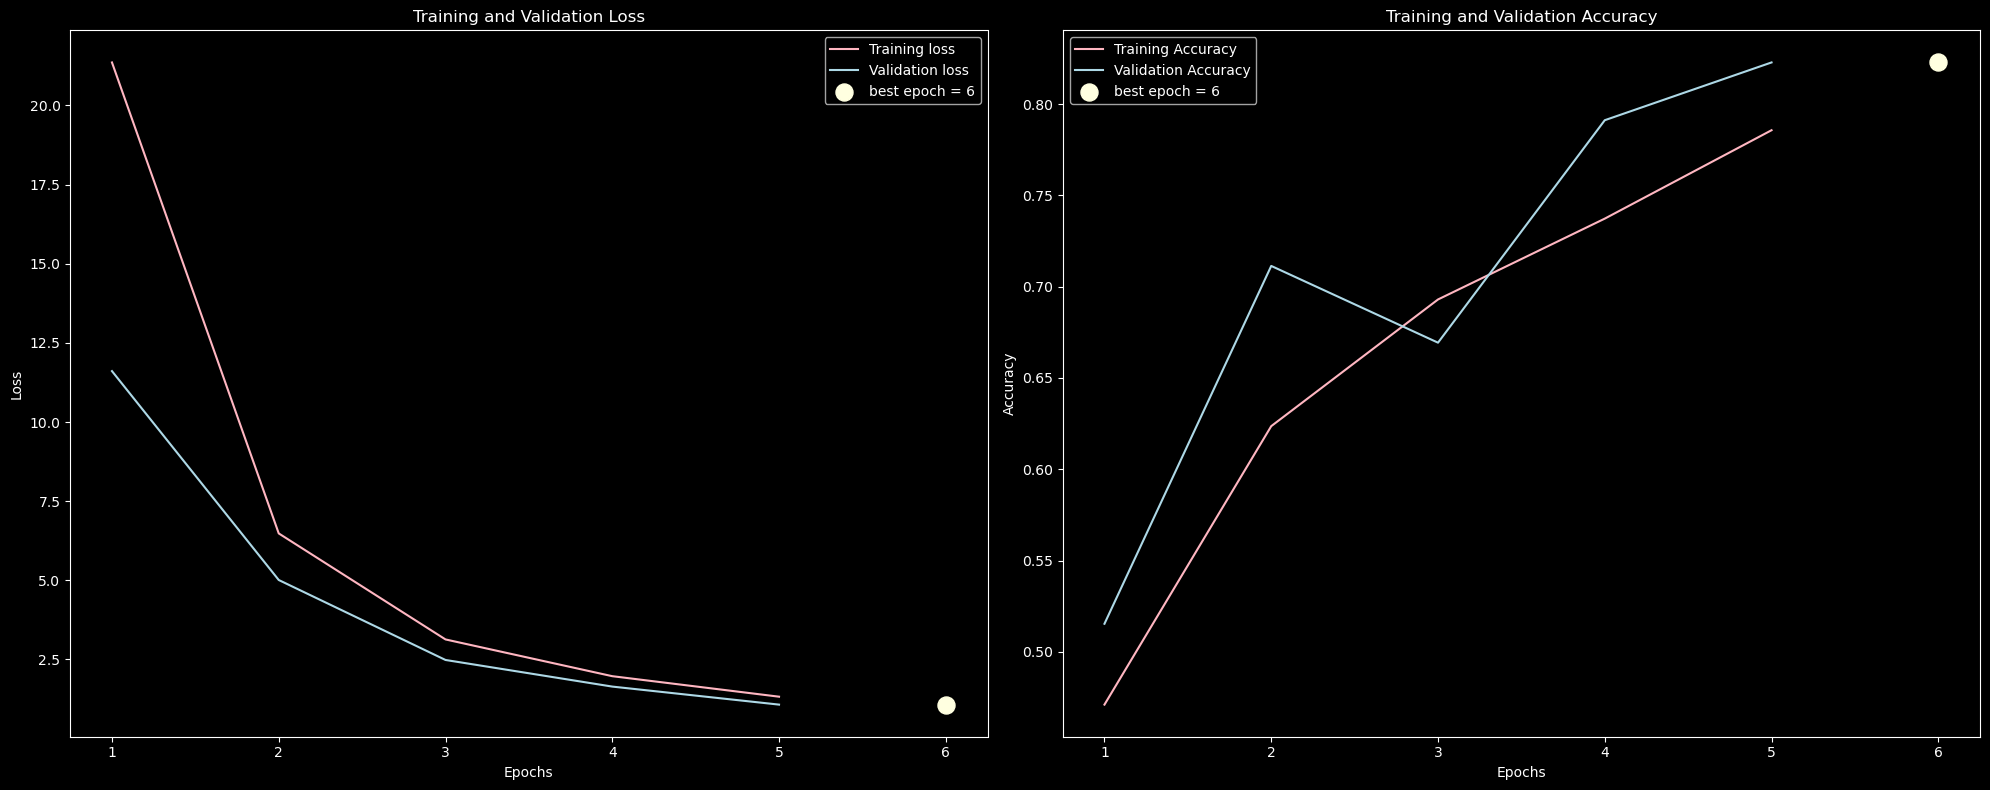

In [ ]:
# Plotting the training history
tr_plot(history, 1)

**NOTE:** If ran with more epochs, accuracy will be much higher. An accuracy of 90% was recorded when ran with 11 epochs previously

In [ ]:
# Creating test generator for evaluation of the model
# Flow test images
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='file_name',
    y_col='label',
    class_mode='categorical',  # Use 'categorical' for multi-class classification
    target_size=img_shape[:2],
    batch_size=batch_size,
    shuffle=False
)

test_generator.class_indices

Found 2116 validated image filenames belonging to 4 classes.


{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}

In [ ]:
# Load the model
model = load_model('incv3_v2.h5')

# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print('Test loss: {:.2f}'.format(test_loss))
print('Test accuracy: {:.2f}%'.format(test_acc * 100))

67/67 [==============================] - 26s 356ms/step - loss: 1.0681 - accuracy: 0.8294
Test loss: 1.07
Test accuracy: 82.94%


In [ ]:
# Make predictions
test_generator.reset()
y_pred = model.predict(test_generator, steps=len(test_generator), verbose=1)
# Convert predictions to class labels
y_pred = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

67/67 [==============================] - 27s 346ms/step


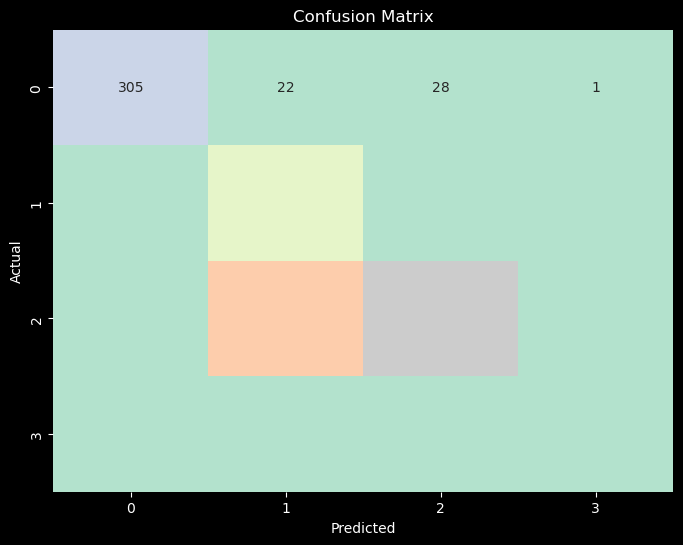

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Pastel2', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Classification report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.86      0.82       356
           1       0.78      0.83      0.81       597
           2       0.87      0.85      0.86      1021
           3       0.91      0.61      0.73       142

    accuracy                           0.83      2116
   macro avg       0.84      0.79      0.80      2116
weighted avg       0.83      0.83      0.83      2116



## **6. Application**

In [ ]:
# Imports needed to run flask server and website
from flask import Flask, render_template, request, jsonify
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.models import load_model
import pickle
import numpy as np

In [ ]:
app = Flask(__name__)

# Load the model
model = load_model('incv3_v2.h5')

# Loading the class indices
with open('class_indices.pkl', 'rb') as f:
    class_indices = pickle.load(f)

# Function to preprocess the image
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Route to handle the upload page
@app.route("/", methods=["GET", "POST"])
def upload_file():
    if request.method == "POST":
        file = request.files["file"]
        if file:
            image_path = "img.jpg"
            file.save(image_path)
            img_array = preprocess_image(image_path)
            preds = model.predict(img_array)
            predicted_index = np.argmax(preds[0])
            predicted_label = list(class_indices.keys())[list(class_indices.values()).index(predicted_index)]
            return jsonify({'predicted_label': predicted_label})
    return render_template('index.html')

if __name__ == "__main__":
    app.run(port=5000, debug=False)

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
